**Image Segmentation with CAMVID**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_07320.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06900.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03000.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_010200_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07963_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_04590_P.png')]

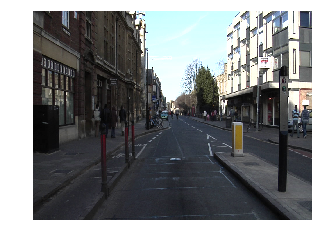

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

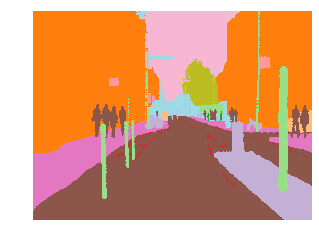

In [57]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [12]:
mask_size = np.array(mask.shape[1:])
mask_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 15, 15, 15],
          [17, 17, 17,  ..., 15, 15, 15],
          [17, 17, 17,  ..., 15, 15, 15]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
v = np.loadtxt(path/'valid.txt',dtype=str)
v

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

In [0]:
size = mask_size//2

In [0]:
src = SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn,classes=codes)

In [0]:
data = src.transform(get_transforms(),size=size,tfm_y=True).databunch(bs=8).normalize(imagenet_stats)

Its important to pass ***tfm_y = True***. This would ensure that when we flip our images in independent dataset, the corresponding masked images are also flipped.

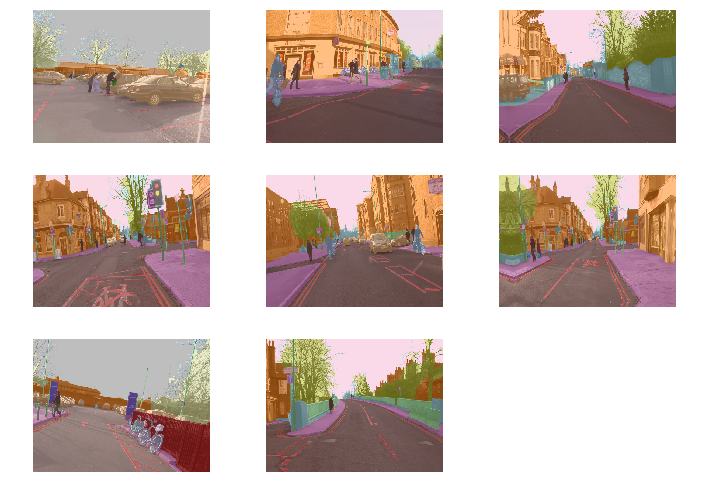

In [18]:
data.show_batch(3,figsize=(10,7))

**Model**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
def acc_camvid(input,target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [66]:
learn = unet_learner(data,models.resnet34,metrics = metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 117235036.36it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


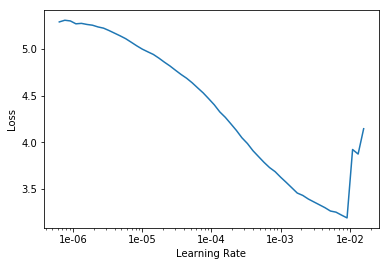

In [69]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(10,1e-3,)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.430614,0.866395,0.796346,01:27
1,0.909167,0.820275,0.814147,01:26
2,0.700736,0.525655,0.864726,01:27
3,0.618774,0.563089,0.853305,01:28
4,0.527823,0.442598,0.872920,01:28
5,0.462992,0.427408,0.874108,01:27
6,0.424707,0.350411,0.903919,01:28
7,0.373198,0.311449,0.909554,01:27
8,0.342492,0.292261,0.917158,01:28
9,0.324530,0.285844,0.918033,01:28


In [0]:
learn.save('stage-1')

In [73]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

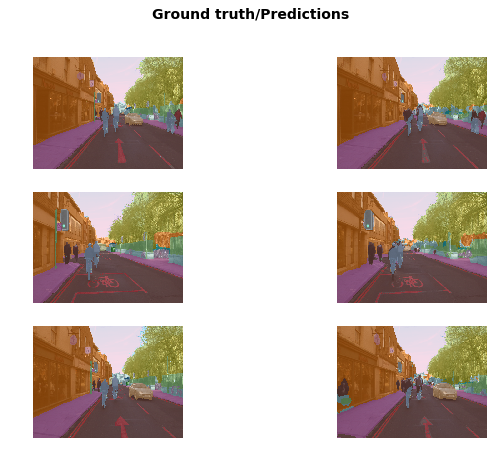

In [74]:
learn.show_results(rows=3,figsize=(10,7))